In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import datetime as dt
import pickle

In [4]:
from wordcloud import WordCloud

def plot_wordcloud_from_tweets(preprocessed_tweets):
  text = " ".join(" ".join(tweet) for tweet in preprocessed_tweets)

  # Generate a word cloud image
  wordcloud = WordCloud(stopwords=[], colormap='winter', background_color="black").generate(text)

  # Display the generated image:
  # the matplotlib way:
  plt.figure(figsize=(10,8))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [5]:
with open("reddit_posts_2022_04_12-03_12_51_PM.pkl", "rb") as fp:
    b = pickle.load(fp)

In [6]:
import pandas as pd
df = pd.DataFrame.from_dict(b)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20888 entries, 0 to 20887
Data columns (total 84 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   _id                            20888 non-null  object 
 1   subreddit                      20888 non-null  object 
 2   author                         20888 non-null  object 
 3   date                           0 non-null      float64
 4   post                           0 non-null      float64
 5   title                          20888 non-null  object 
 6   upvote_ratio                   20888 non-null  float64
 7   all_awardings                  20888 non-null  object 
 8   allow_live_comments            20888 non-null  float64
 9   author_flair_css_class         0 non-null      object 
 10  author_flair_richtext          20884 non-null  object 
 11  author_flair_text              1015 non-null   object 
 12  author_flair_type              20884 non-null 

In [7]:
df['titled_selftext'] = df['title'] + " " + df['selftext'] 

In [8]:
import datetime as dt
x0 = dt.datetime.fromtimestamp(df['created_utc'][0])

In [9]:
df['created_at_ymd'] = df['created_utc'].apply(lambda x: dt.datetime.fromtimestamp(x).strftime("%Y_%m_%d"))

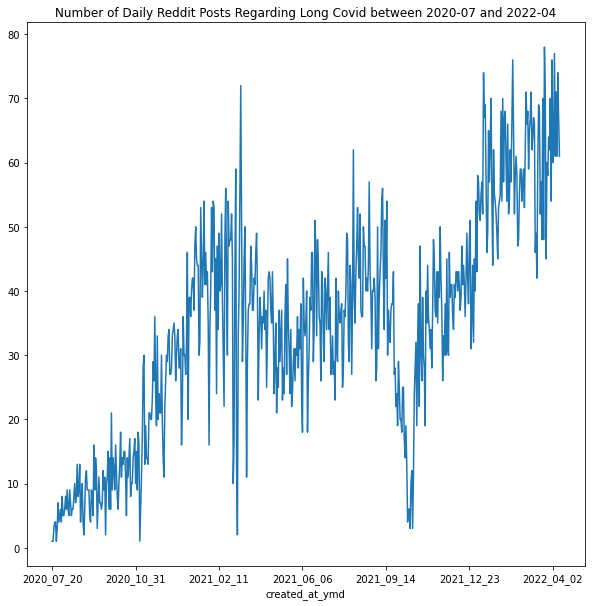

In [10]:
df.groupby(by = ['created_at_ymd']).count()['id'].plot(title="Number of Daily Reddit Posts Regarding Long Covid between 2020-07 and 2022-04", figsize=(10,10))
plt.show()

### Initial Data Visualization

### Data Preprocessing

In [15]:
import re, string, unicodedata
import nltk
import contractions # expanding contractions
import inflect # natural language related tasks of generating plurals, singular nouns, etc.
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import string


#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

In [16]:
import nltk
#nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hayadi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hayadi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [17]:
import sys
sys.path.append("../utils/preprocess")

In [90]:
from preprocess import Preprocess
prep = Preprocess()

In [91]:
def multiple_replacer(*key_values):
    replace_dict = dict(key_values)
    replacement_function = lambda match: replace_dict[match.group(0)]
    pattern = re.compile("|".join([re.escape(k) for k, v in key_values]), re.M)
    return lambda string: pattern.sub(replacement_function, string)

def multiple_replace(string, *key_values):
    return multiple_replacer(*key_values)(string)

replacements = (u"view poll", u"")

In [92]:
multiple_replace("really suffering from long covid view poll", replacements)

'really suffering from long covid '

In [93]:
def preprocess_post(post, replacements, stemming=True, numbers_processing='replace'):
    
    post = prep.replace_contractions(post)
    post = prep.replace_special_words(post)
    post = prep.replace_hashtags_URL_USER(post, mode_URL="delete", mode_Mentions="delete", mode_Hashtag="replace")
    post = prep.tokenize(post)
    post = prep.remove_punctuation(post)
    post = prep.preprocess_emojis(post)
    post = prep.preprocess_emoticons(post)
    post = prep.remove_non_ascii(post)
    post = prep.to_lowercase(post)
    post = prep.replace_numbers(post, mode=numbers_processing)
    post = prep.lemmatize_verbs(post)
    post = prep.remove_stopwords(post)
    if replacements:
        post= multiple_replace(" ".join(post), *replacements)
        post=post.split()
    if stemming:
        post = prep.stem_words(post)
    return post

def preprocess_posts(posts, *replacements, stemming=True, numbers_processing='replace'):
    return [" ".join(preprocess_post(post, replacements, stemming, numbers_processing)) for post in posts if post]

In [94]:
replacements = (u"view poll", u"")

df['clean_selftext_stemmed_without_numbers'] = preprocess_posts(df['selftext'], replacements, numbers_processing='delete')
df['clean_selftext_stemmed_with_numbers'] = preprocess_posts(df['selftext'], replacements)
df['clean_selftext_unstemmed_without_numbers'] = preprocess_posts(df['selftext'], replacements, stemming=False, numbers_processing='delete')
df['clean_selftext_unstemmed_with_numbers'] = preprocess_posts(df['selftext'], replacements, stemming=False)

INFO: Could not replace emoticon: ;d of the word: ;d (<class 'KeyError'>, KeyError(';d'), <traceback object at 0x0000018167C4B040>)
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 😟 -> delete emoji :worried_face:
INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🍁 -> delete emoji :maple_leaf:
INFO: Could not replace emoticon: ;d of the word: ;d (<class 'KeyError'>, KeyError(';d'), <traceback object at 0x0000018167C28FC0>)
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: Could not replace emoticon: ;d of the word: ;d 

INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🤷 -> delete emoji :person_shrugging:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🖤 -> delete emoji :black_heart:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: Could not replace emoticon: Dx of the word: Dx (<class 'KeyError'>, KeyError('Dx'), <traceback object at 0x0000018167BBEA40>)
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 😑 -> del

INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: Could not replace emoticon: ;d of the word: ;d (<class 'KeyError'>, KeyError(';d'), <traceback object at 0x0000018167CD31C0>)
INFO: No category set for emoji 😋 -> delete emoji :face_savouring_delicious_food:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😜 -> delete emoji :face_with_stuck-out_tongue_&_winking_eye:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: Could not replace emoticon: ;d of the word: ;d (<class 'KeyError'>, KeyError(';d'), <traceback object at 0x0000018167B6D440>)
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for em

INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji ✊ -> delete emoji :raised_fist:
INFO: Could not replace emoticon: ;d of the word: ;d (<class 'KeyError'>, KeyError(';d'), <traceback object at 0x0000018167B21880>)
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji ‼ -> delete emoji :double_exclamation_mark:
INFO: No category set for emoji ‼ -> 

INFO: No category set for emoji 🍻 -> delete emoji :clinking_beer_mugs:
INFO: No category set for emoji 😏 -> delete emoji :smirking_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji ☕ -> delete emoji :hot_beverage:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🖤 -> delete emoji :black_heart:
INFO: No category set for emoji 🌈 -> delete emoji :rainbow:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO:

INFO: No category set for emoji 🎵 -> delete emoji :musical_note:
INFO: No category set for emoji 🎵 -> delete emoji :musical_note:
INFO: No category set for emoji 🎵 -> delete emoji :musical_note:
INFO: No category set for emoji 🎵 -> delete emoji :musical_note:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: Could not replace emoticon: ;d of the word: ;d (<class 'KeyError'>, KeyError(';d'), <traceback object at 0x0000018167BB5B00>)
INFO: No category set for emoji ☝ -> delete emoji :index_pointing_up:
INFO: No category set for emoji 😪 -> delete emoji :sleepy_face:
INFO: No category set for emoji 🐐 -> delete emoji :goat:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 👏 -> delete emoji :clapping_hands:
INFO: No category set for emoji 💯 -> delete emoji :hundred_points:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😅 -> delete emoji :sm

INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🎫 -> delete emoji :ticket:
INFO: No category set for emoji 👻 -> delete emoji :ghost:
INFO: Could not replace emoticon: Dx of the word: Dx (<class 'KeyError'>, KeyError('Dx'), <traceback object at 0x0000018167C7AD40>)
INFO: No category set for emoji 👉 -> delete emoji :backhand_index_pointing_right:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: Could not replace emoticon: ;d of the word: ;d (<class 'KeyError'>, KeyError(';d'),

INFO: No category set for emoji 📷 -> delete emoji :camera:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji ✳ -> delete emoji :eight-spoked_asterisk:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 😑 -> delete emoji :expressionless_face:
INFO: No category set for emoji 🔍 -> delete emoji :left-pointing_magnifying_glass:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 📣 -> delete emoji :megaphone:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set fo

INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: Could not replace emoticon: ;d of the word: ;d (<class 'KeyError'>, KeyError(';d'), <traceback object at 0x0000018167BC96C0>)
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 💪 -> delete emoji :flexed_biceps:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: Could not replace emoticon: ;d of the word: ;d (<class 'KeyError'>, KeyError(';d'), <traceback object at 0x0000018167CEEE40>)
INFO: No category set for emoji 🤝 -> delete emoji :handshake:
INFO: No category set for emoji 📣 -> delete emoji :megaphone:
INFO: No category set for emoji 📣 -> delete emoji :megaphone:
INFO: Could not replace emoticon: ;d of the word: ;d (<class 'KeyError'>, KeyError(';d'), <traceback object at 0x0000018167D43400>)
INFO: No category set for emoji 🖕 -> delete emoji :middle_

INFO: No category set for emoji 👍 -> delete emoji :thumbs_up:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: Could not replace emoticon: ;d of the word: ;d (<class 'KeyError'>, KeyError(';d'), <traceback object at 0x0000018167B5AEC0>)
INFO: No category set for emoji ☹ -> delete emoji :frowning_face:
INFO: Could not replace emoticon: ;d of the word: ;d (<class 'KeyError'>, KeyError(';d'), <traceback object at 0x0000018167CD55C0>)
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🤦 -> delete emoji :person_facepalming:
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: Could not replace emoticon: ;d of

INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji ☀ -> delete emoji :sun:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 😌 -> delete emoji :relieved_face:
INFO: Could not replace emoticon: ;d of the word: ;d (<class 'KeyError'>, KeyError(';d'), <traceback object at 0x0000018169298500>)
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji ✅ -> delete emoji :white_heavy_check_mark:
INFO: No category set for emoji ✅ -> delete emoji :white_heavy_check_mark:
INFO: No category set for emoji ✅ -> delete emoji :white_heavy_check_mark:
INFO: No category set for emoji ✅ -> delete emoji :white_heavy_check_mark:
INFO: No category

INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 📈 -> delete emoji :chart_increasing:
INFO: Could not replace emoticon: ;d of the word: ;d (<class 'KeyError'>, KeyError(';d'), <traceback object at 0x0000018166D61600>)
INFO: No category set for emoji 🤞 -> delete emoji :crossed_fingers:
INFO: Could not replace emoticon: ;d of the word: ;d (<class 'KeyError'>, KeyError(';d'), <traceback object at 0x0000018167D961C0>)
INFO: No category set for emoji 😉 -> delete emoji :winking_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🎵 -> delete emoji :musical_note:
INFO: Could not replace emoticon: ;d of the word: ;d (<class 'KeyError'>, KeyError(';d'), <traceback object at 0x0000018167CF9A40>)
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🙈 -> delete emoji :see-no-evil_monkey:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO

INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: Could not replace emoticon: ;d of the word: ;d (<class 'KeyError'>, KeyError(';d'), <traceback object at 0x0000018167C51540>)
INFO: Could not replace emoticon: ;d of the word: ;d (<class 'KeyError'>, KeyError(';d'), <traceback object at 0x0000018167B0B140>)
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 😬 -> delete emoji :grimacing_face:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🙏 -> delete emoji :folde

INFO: No category set for emoji ⚠ -> delete emoji :warning:
INFO: No category set for emoji 🤡 -> delete emoji :clown_face:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO: No category set for emoji 😐 -> delete emoji :neutral_face:
INFO: No category set for emoji 😟 -> delete emoji :worried_face:
INFO: No category set for emoji 😟 -> delete emoji :worried_face:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 😅 -> delete emoji :smiling_face_with_open_mouth_&_cold_sweat:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 🌷 -> delete emoji :tulip:
INFO: No category set for emoji 🌞 -> delete emoji :sun_with_face:
INFO: No category set for emoji 🔥 -> delete emoji :fire:
INFO: No category set for emoji 😎 -> delete emoji :smiling_face_with_sunglasses:
INFO: No category set for emoji ✌ -> delete emoji :victory_hand:
INFO: No category set for emoji ™ -> delete emoji :trade_mark:
INFO: No cat

INFO: No category set for emoji 📷 -> delete emoji :camera:
INFO: No category set for emoji ☝ -> delete emoji :index_pointing_up:
INFO: No category set for emoji 📣 -> delete emoji :megaphone:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji ✔ -> delete emoji :heavy_check_mark:
INFO: No category set for emoji 🔹 -> delete emoji :small_blue_diamond:
INFO: No category set for emoji 🔹 -> delete emoji :small_blue_diamond:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 📷 -> delete emoji :camera:
INFO: No category set for emoji 😣 -> delete emoji :persevering_face:
INFO: No category set for emoji 👀 -> delete emoji :eyes:
INFO: No category set for emoji 👋 -> delete emoji :waving_hand:
INFO

In [96]:
df['clean_selftext_unstemmed_without_numbers'].to_list()

['foods best tolerate',
 'currently month 7.5 lh voyage breathe issue briefly start deal tachycardia palpitation pot fatigue general orthostatic intolerance better part year like almost test subject tell story accord modern medical science pinnacle good health despite somewhat overweight nothing structural wrong cardiologist recently recommend exercise much able without make symptom worse conservative approach many talk much possible slowly gradually build largely bedridden little last month start essentially scratch early day still push gym hour-long walk suffer least know better currently 15-18 minute walk day essentially around block week slowly add cul-de-sacs side-streets know least current distance without lay week symptom flare average 3500ish step per day work remotely thank fuck spend day rest much exercise look like maybe change time modify instance use climber runner grow include new like stretch exercise maybe simple keep semi-active housekeeping routine tip build back fort

In [98]:
df.to_csv('reddit_posts_2022_04_12-03_12_51_PM_selftext_preprocessed.csv')

In [99]:
replacements = (u"view poll", u"")

df['clean_title_stemmed_without_numbers'] = preprocess_posts(df['title'], replacements, numbers_processing='delete')
df['clean_title_stemmed_with_numbers'] = preprocess_posts(df['title'], replacements)
df['clean_title_unstemmed_without_numbers'] = preprocess_posts(df['title'], replacements, stemming=False, numbers_processing='delete')
df['clean_title_unstemmed_with_numbers'] = preprocess_posts(df['title'], replacements, stemming=False)

INFO: No category set for emoji 📷 -> delete emoji :camera:
INFO: No category set for emoji ✨ -> delete emoji :sparkles:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 💀 -> delete emoji :skull:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 😴 -> delete emoji :sleeping_face:
INFO: No category set for emoji 🖤 -> delete emoji :black_heart:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji ⁉ -> delet

INFO: No category set for emoji 🖤 -> delete emoji :black_heart:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji 😫 -> delete emoji :tired_face:
INFO: No category set for emoji 🤔 -> delete emoji :thinking_face:
INFO: No category set for emoji ⁉ -> delete emoji :exclamation_question_mark:
INFO: No category set for emoji ® -> delete emoji :registered:
INFO: No category set for emoji 🎉 -> delete emoji :party_popper:
INFO: No category set for emoji 🙏 -> delete emoji :folded_hands:
INFO: No category set for emoji 😖 -> delete emoji :confounded_face:
INFO: No category set for emoji ✅ -> delete emoji :white_heavy_check_mark:
INFO: No category set for emoji 💔 -> delete emoji :broken_heart:
INFO:

In [100]:
df.to_csv('reddit_posts_2022_04_12-03_12_51_PM_selftext_title_preprocessed.csv')

In [101]:
df['clean_title_stemmed_without_numbers'].to_list()

['safe food',
 'much exercis',
 'improv quit lot stop post',
 'lose 18lbs due longcovid start gain weight',
 'symptom debilit still suck relat',
 'actual articl scientif paper suggest long haul anxieti',
 'long hauler specif tast smell lose chang',
 'drink',
 'know caus twitch tremor',
 'brain fog',
 'recov daili low fever',
 'er last night despit recov month',
 'someon explain cure possibl',
 'gi rumbl nois',
 'resourc thought fellow long hauler',
 'impuls intrus thought',
 'exercis',
 'day 2nd reinfect month lh finish vaccin',
 'justin foster inspir',
 'care water kid',
 'claritin anoth antihistamin',
 'littl better everyday',
 'dizzi treadmil month',
 'post vax long hauler',
 'feel like differ person',
 'constant headach pfizer vaccin',
 'multipl mri brain neck spine sinc long haul',
 'video graphic bc007 mechan',
 'month mark post viral fatigu step forward everi step back',
 'long haul symptom post first jab month anitbodi test show previous unknown covid infect',
 'want life back'

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20888 entries, 0 to 20887
Data columns (total 94 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   _id                                       20888 non-null  object 
 1   subreddit                                 20888 non-null  object 
 2   author                                    20888 non-null  object 
 3   date                                      0 non-null      float64
 4   post                                      0 non-null      float64
 5   title                                     20888 non-null  object 
 6   upvote_ratio                              20888 non-null  float64
 7   all_awardings                             20888 non-null  object 
 8   allow_live_comments                       20888 non-null  float64
 9   author_flair_css_class                    0 non-null      object 
 10  author_flair_richtext             

In [104]:
replacements = (u"view poll", u"")

df['clean_titled_selftext_stemmed_without_numbers'] = df['clean_selftext_stemmed_without_numbers'] + " " + df['clean_title_stemmed_without_numbers'] 
df['clean_titled_selftext_stemmed_with_numbers'] = df['clean_selftext_stemmed_with_numbers'] + " " + df['clean_title_stemmed_with_numbers'] 
df['clean_titled_selftext_unstemmed_without_numbers'] = df['clean_selftext_unstemmed_without_numbers'] + " " + df['clean_title_unstemmed_without_numbers'] 
df['clean_titled_selftext_unstemmed_with_numbers'] = df['clean_selftext_unstemmed_with_numbers'] + " " + df['clean_title_unstemmed_with_numbers'] 

In [ ]:
df.dropna(axis=0, how='any', thresh=None, subset=['clean_selftext_unstemmed_with_numbers'], inplace=True)

In [ ]:
indices = df[df['clean_selftext_unstemmed_with_numbers'].str.len() < 4 ]['clean_selftext_unstemmed_with_numbers'].index
df.drop(indices, inplace=True)

In [107]:
df.to_csv('reddit_posts_2022_04_12-03_12_51_PM_clean.csv')

In [108]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hayadi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [111]:
custom_stop_words = ['covid', 'symptom', 'like', 'feel', 'day', 'month', 'anyone', 'long', 
                     'time', 'week', 'back', 'test', 'start', 'know', 'would', 'think', 'since']

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in custom_stop_words] for doc in texts]

data_words = remove_stopwords(df['clean_selftext_unstemmed_without_numbers'])
titled_data_words = remove_stopwords(df['clean_titled_selftext_unstemmed_without_numbers'])

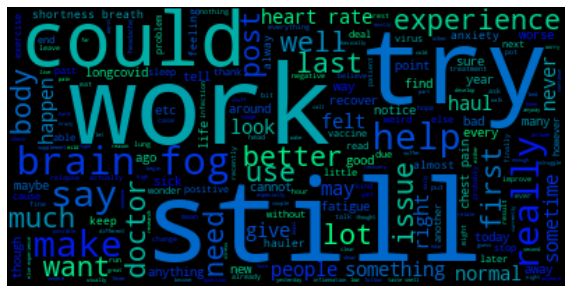

In [112]:
plot_wordcloud_from_tweets(data_words)

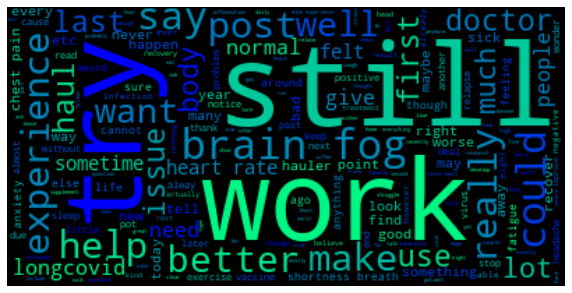

In [113]:
plot_wordcloud_from_tweets(titled_data_words)

In [114]:
# Use list comprehension to convert a list of lists to a flat list 
all_words = [item for elem in data_words for item in elem]
titled_all_words = [item for elem in titled_data_words for item in elem]

In [116]:
from collections import Counter
word_frequencies = Counter(all_words)
word_frequencies.most_common(20)

[('pain', 7699),
 ('help', 7030),
 ('still', 6751),
 ('work', 6369),
 ('experience', 5910),
 ('try', 5794),
 ('heart', 5783),
 ('make', 5750),
 ('really', 5693),
 ('could', 5673),
 ('doctor', 5632),
 ('issue', 5457),
 ('say', 5387),
 ('brain', 5267),
 ('better', 5237),
 ('fatigue', 4813),
 ('else', 4762),
 ('want', 4685),
 ('last', 4602),
 ('much', 4569)]

In [117]:
word_frequencies = Counter(titled_all_words)
word_frequencies.most_common(20)

[('pain', 8520),
 ('help', 7874),
 ('still', 7063),
 ('work', 6700),
 ('experience', 6418),
 ('heart', 6216),
 ('try', 6137),
 ('issue', 6016),
 ('make', 5949),
 ('doctor', 5936),
 ('really', 5857),
 ('could', 5845),
 ('brain', 5829),
 ('better', 5564),
 ('else', 5517),
 ('say', 5476),
 ('post', 5358),
 ('fatigue', 5177),
 ('want', 4809),
 ('people', 4749)]

In [53]:
#see that index for assessing topic modeling algorithms or for choosing the value of n (the number of topics to work on) 

### Co-occurences 

In [120]:
from nltk import bigrams
import itertools
import collections

# Create list of lists containing bigrams in redit posts
terms_bigram = [list(bigrams(post)) for post in data_words]
# Flatten list of bigrams in clen tweets
bigrams = list(itertools.chain(*terms_bigram))
bigram_counts = collections.Counter(bigrams)

In [121]:
NB_PAIRS = 100
bigram_counts.most_common(NB_PAIRS)

[(('brain', 'fog'), 3334),
 (('heart', 'rate'), 1951),
 (('chest', 'pain'), 1694),
 (('shortness', 'breath'), 1516),
 (('else', 'experience'), 888),
 (('taste', 'smell'), 766),
 (('blood', 'pressure'), 675),
 (('year', 'old'), 668),
 (('smell', 'taste'), 648),
 (('panic', 'attack'), 643),
 (('sore', 'throat'), 592),
 (('last', 'year'), 547),
 (('side', 'effect'), 544),
 (('immune', 'system'), 534),
 (('body', 'ache'), 533),
 (('blood', 'work'), 507),
 (('heart', 'palpitation'), 488),
 (('pretty', 'much'), 454),
 (('doctor', 'say'), 443),
 (('really', 'bad'), 432),
 (('make', 'worse'), 420),
 (('joint', 'pain'), 413),
 (('fall', 'asleep'), 386),
 (('gi', 'issue'), 372),
 (('ct', 'scan'), 368),
 (('last', 'night'), 357),
 (('mental', 'health'), 342),
 (('left', 'side'), 342),
 (('much', 'better'), 339),
 (('sense', 'smell'), 332),
 (('make', 'sense'), 328),
 (('year', 'ago'), 314),
 (('mild', 'case'), 311),
 (('chest', 'tightness'), 304),
 (('hi', 'everyone'), 302),
 (('want', 'share'), 